Processing Alaska (RGI2000-v7.0-G-01-13271)...
  - Map saved: RGI2000-v7.0-G-01-13271_map.png


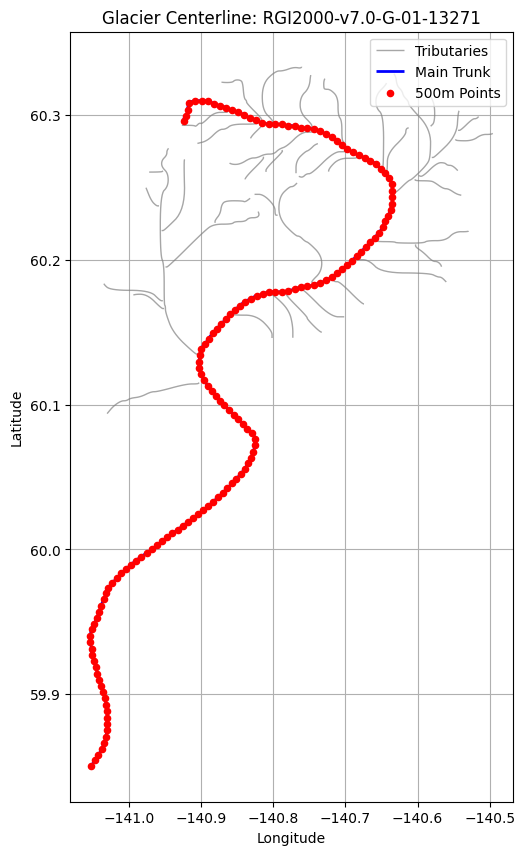


Success! Coordinates saved to 'glacier_centerline_points_500m.csv'


In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP: Define the glaciers and their corresponding Shapefiles
# You must have the .shp, .shx, and .dbf files in the same folder.
config = [
    {
        "region_name": "Alaska",
        "glacier_id": "RGI2000-v7.0-G-01-13271",
        "file_path": "RGI2000-v7.0-L-01_alaska/RGI2000-v7.0-L-01_alaska.shp",
        "proj_epsg": 3338  # Alaska Albers Equal Area (good for metric distance)
    }
    # ,
    # {
    #     "region_name": "Central Asia",
    #     "glacier_id": "RGI2000-v7.0-G-13-05693",
    #     "file_path": "RGI2000-v7.0-L-13_central_asia.shp", # MISSING IN UPLOAD
    #     "proj_epsg": 102027 # Asia North Albers (or use UTM)
    # }
]

all_points_data = []

for item in config:
    print(f"Processing {item['region_name']} ({item['glacier_id']})...")
    
    try:
        # Load the shapefile
        gdf = gpd.read_file(item['file_path'])
        
        # Filter for the specific glacier
        glacier_gdf = gdf[gdf['rgi_g_id'] == item['glacier_id']].copy()
        
        if glacier_gdf.empty:
            print(f"  - Glacier ID {item['glacier_id']} not found in file.")
            continue
            
        # Select the Main Trunk (is_main = 1) for the 500m sampling
        # We plot ALL lines, but only sample points along the main flowline.
        main_trunk = glacier_gdf[glacier_gdf['is_main'] == 1].copy()
        
        # Reproject to metric CRS to calculate 500m spacing accurately
        main_trunk_proj = main_trunk.to_crs(epsg=item['proj_epsg'])
        
        # Generate points every 500m
        points_list = []
        for idx, row in main_trunk_proj.iterrows():
            line = row['geometry']
            # Create distances: 0, 500, 1000, ... up to line length
            distances = np.arange(0, line.length, 500)
            
            for dist in distances:
                pt_proj = line.interpolate(dist)
                points_list.append(pt_proj)
                
        # Convert points back to WGS84 (Lat/Lon) for export
        gdf_points_proj = gpd.GeoDataFrame(geometry=points_list, crs=item['proj_epsg'])
        gdf_points_wgs84 = gdf_points_proj.to_crs(epsg=4326)
        
        # Store for CSV
        for i, pt in enumerate(gdf_points_wgs84.geometry):
            all_points_data.append({
                "Region": item['region_name'],
                "Glacier_ID": item['glacier_id'],
                "Point_Index": i,
                "Longitude": pt.x,
                "Latitude": pt.y,
                "Distance_m": i * 500
            })
            
        # --- PLOTTING ---
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # 1. Plot all centerline segments (Tributaries) in Grey
        glacier_gdf.plot(ax=ax, color='grey', linewidth=1, alpha=0.7, label='Tributaries')
        
        # 2. Plot Main Trunk in Blue
        # (We use the WGS84 version for plotting to match the axis coords)
        main_trunk.plot(ax=ax, color='blue', linewidth=2, label='Main Trunk')
        
        # 3. Plot 500m Points in RED
        gdf_points_wgs84.plot(ax=ax, color='red', markersize=20, label='500m Points', zorder=5)
        
        ax.set_title(f"Glacier Centerline: {item['glacier_id']}")
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.legend()
        ax.grid(True)
        
        # Save Plot
        filename = f"{item['glacier_id']}_map.png"
        plt.savefig(filename)
        print(f"  - Map saved: {filename}")
        plt.show()

    except Exception as e:
        print(f"  - Could not process file {item['file_path']}: {e}")

# Save all points to CSV
if all_points_data:
    df_out = pd.DataFrame(all_points_data)
    df_out.to_csv("glacier_centerline_points_500m.csv", index=False)
    print("\nSuccess! Coordinates saved to 'glacier_centerline_points_500m.csv'")
else:
    print("\nNo data extracted.")

Loading shapefile...
Found 42 segments (Main + Tributaries).
Threshold Distance: 49356 meters from terminus.
Saved data to RGI2000-v7.0-G-01-13271_centerline_500m.csv


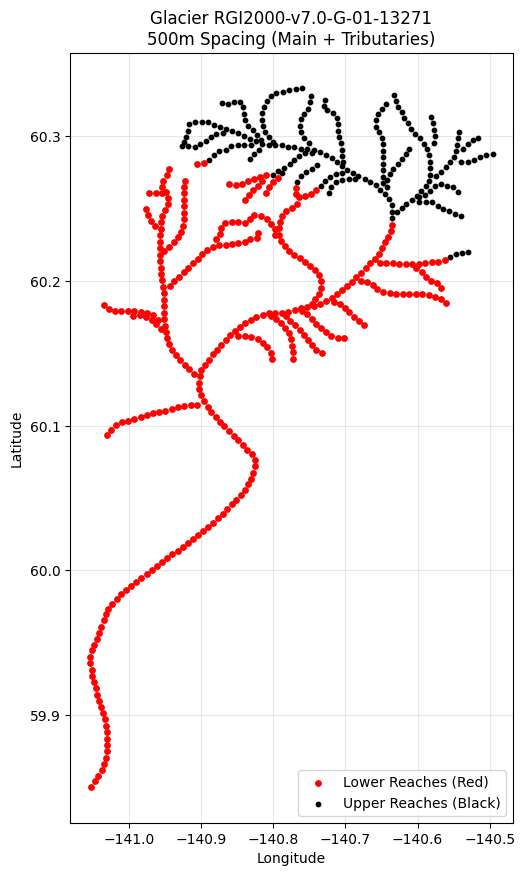

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

# --- CONFIGURATION ---
# 1. Path to your Shapefile (Update this to your local path)
SHP_PATH = "RGI2000-v7.0-L-01_alaska/RGI2000-v7.0-L-01_alaska.shp" 

# 2. Target Glacier ID
TARGET_ID = "RGI2000-v7.0-G-01-13271"

# 3. Threshold for "Red" vs "Black" points
# The paper uses Elevation. Since we lack a DEM here, we use "Distance from Terminus".
# Points within this percentage of the total length are "Red" (Lower Reaches).
LOWER_FRACTION = 0.620 

# --- PROCESSING ---

# 1. Load Data
print("Loading shapefile...")
gdf = gpd.read_file(SHP_PATH)

# 2. Filter for Target Glacier
glacier_gdf = gdf[gdf['rgi_g_id'] == TARGET_ID].copy()
if glacier_gdf.empty:
    raise ValueError(f"Glacier {TARGET_ID} not found in file.")

print(f"Found {len(glacier_gdf)} segments (Main + Tributaries).")

# 3. Project to Meters (Crucial for 500m spacing)
# Using Alaska Albers Equal Area (EPSG:3338)
glacier_gdf_proj = glacier_gdf.to_crs(epsg=3338)

# 4. Identify Terminus (Reference point for threshold)
# We assume the terminus is the point with the lowest Y coordinate (South-most) 
# on the main trunk.
main_trunk = glacier_gdf_proj[glacier_gdf_proj['is_main'] == 1]
if not main_trunk.empty:
    # Get the single longest line for the main trunk
    longest_idx = main_trunk.length.idxmax()
    trunk_geom = main_trunk.loc[longest_idx, 'geometry']
    
    # RGI lines usually go Top -> Bottom. Check endpoints.
    # We take the point with the minimum Y value as the terminus.
    coords = list(trunk_geom.coords)
    p1, p2 = Point(coords[0]), Point(coords[-1])
    terminus_pt = p1 if p1.y < p2.y else p2
    
    # Calculate Max Length for Thresholding
    max_length_m = trunk_geom.length
else:
    # Fallback if no is_main=1 found
    min_y_pt = glacier_gdf_proj.geometry.bounds.miny.min()
    terminus_pt = Point(glacier_gdf_proj.total_bounds[0], min_y_pt)
    max_length_m = 50000 # Dummy fallback

threshold_dist_m = max_length_m * LOWER_FRACTION
print(f"Threshold Distance: {threshold_dist_m:.0f} meters from terminus.")

# 5. Generate 500m Points
points_data = []

for idx, row in glacier_gdf_proj.iterrows():
    line = row['geometry']
    segment_id = row['segment_id']
    is_main = row['is_main']
    
    # Interpolate points every 500m
    distances = np.arange(0, line.length, 500)
    
    for dist in distances:
        pt = line.interpolate(dist)
        
        # --- THRESHOLD LOGIC (Red vs Black) ---
        # Calculate distance from this point to the Terminus
        dist_to_term = pt.distance(terminus_pt)
        
        # CLASSIFICATION:
        # If distance < Threshold: RED (Lower Reaches / Ablation Zone)
        # If distance > Threshold: BLACK (Upper Reaches / Accumulation Zone)
        color_class = "Red" if dist_to_term < threshold_dist_m else "Black"
        
        # Store Data (Projected and WGS84)
        # We transform back to WGS84 (Lon/Lat) for the CSV
        # Note: simplistic un-projection for single point
        # A better way is to gather all and unproject at once, but this works for loops.
        pt_wgs84 = gpd.GeoSeries([pt], crs=3338).to_crs(4326)[0]
        
        points_data.append({
            "segment_id": segment_id,
            "is_main": is_main,
            "dist_along_line": dist,
            "dist_from_terminus": dist_to_term,
            "longitude": pt_wgs84.x,
            "latitude": pt_wgs84.y,
            "class": color_class
        })

# 6. Save to CSV
df_out = pd.DataFrame(points_data)
csv_filename = f"{TARGET_ID}_centerline_500m.csv"
df_out.to_csv(csv_filename, index=False)
print(f"Saved data to {csv_filename}")

# 7. Plotting (Replicating Paper Style)
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the lines (grey background)
glacier_gdf.to_crs(4326).plot(ax=ax, color='lightgrey', linewidth=1, zorder=1)

# Plot RED points (Lower Reaches)
red_df = df_out[df_out['class'] == 'Red']
ax.scatter(red_df.longitude, red_df.latitude, c='red', s=15, label='Lower Reaches (Red)', zorder=3)

# Plot BLACK points (Upper Reaches)
black_df = df_out[df_out['class'] == 'Black']
ax.scatter(black_df.longitude, black_df.latitude, c='black', s=10, label='Upper Reaches (Black)', zorder=2)

ax.set_title(f"Glacier {TARGET_ID}\n500m Spacing (Main + Tributaries)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{TARGET_ID}_map.png")
plt.show()